In [1]:
import os
import ruamel.yaml as yaml
import matplotlib.pyplot as plt
import numpy as np

## Obligatory paths

In [2]:
path_to_local_folder = os.path.expanduser('data_samples')
filter_include = ["synth", "A04hm_H1","nocond"]
filter_exclude = ["failed"]

conf_name = "common_files/config_mcmc_bayes.yaml"

# načtení dat a formatovani dat

In [3]:
from raw_data import MultiRawData
from results_aggregator import get_subfolder_paths_processed, filter_datasets

subfolders = get_subfolder_paths_processed(path_to_local_folder)
subfolders_filt = filter_datasets(subfolders, filter_include, filter_exclude)

all_raw_data = MultiRawData()
all_raw_data.load_from_folders_hdf5(subfolders_filt)
# load yaml config from the first folder in the list, it will be used for likelihood evaluation
conf = yaml.safe_load(open(os.path.join(subfolders_filt[0], conf_name), 'r'))
subfolders_filt

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


['data_samples/borehole_H1/synth_A04hm_H1_nocond_20230419',
 'data_samples/borehole_H1/synth_A04hm_H1_nocond_nocorr_20230602',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230618a',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230618b',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230618c',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230619',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230619b',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230619c']

## Filtrovaní dat

In [4]:
# filter data so only those with model are used and only ones with tag 1 = coverged
raw_data_filtered = all_raw_data.filter(types=[0, 2], tags=[1])
raw_data_filtered.print_statistics()

raw data: no_samples 167632
raw data: no_nonconverging 0
raw data: p (167632, 8)
raw data: w (167632, 1)
raw_data: np.sum(weights): 1950105.0
raw_data: all_sizes: {'types': (167632,), 'stages': (167632,), 'chains': (167632,), 'tags': (167632,), 'parameters': (167632, 8), 'observations': (167632, 26), 'parameters_normalized': (167632, 8), 'weights': (167632, 1), 'run_ids': (167632,)}


## Rekonstrukce modelu šumu pro výpočet likelihoodu

In [5]:
import surrDAMH_gaussian_process as gp

def compute_log_likelihood_all(data):
    # reconstruct covariance of the noise
    cov_mat = gp.assemble_covariance_matrix(conf['noise_model'])

    # rewritten likelihood for our model
    def get_log_likelihood_multivariate(observations, G_sample,noise_std):
        v = observations - G_sample.ravel()
        invCv = np.linalg.solve(noise_std,v)
        return -0.5*np.dot(v,invCv)

    # measurement from conf
    y_orig = np.array(conf['problem_parameters']['observations'])

    log_likelihood = np.zeros((data.shape[0],1))
    for idx,obs in enumerate(data):
        log_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)
    
    return log_likelihood

## Vytvoření datasetu pro trénování a testování

In [6]:
data = raw_data_filtered.parameters_normalized
obs = raw_data_filtered.observations

obs_likelihood = compute_log_likelihood_all(obs)


9.357622968840175e-14 2.061153622438558e-09 4.5399929762484854e-05 0.01831563888873418


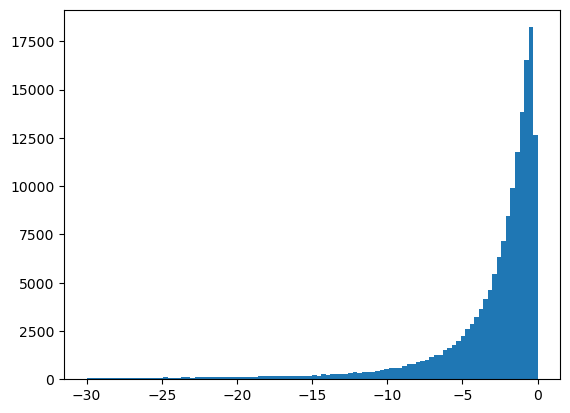

In [7]:
_ = plt.hist(obs_likelihood, bins=100, range=(-30, 0))
print(np.exp(-30), np.exp(-20), np.exp(-10), np.exp(-4))

In [8]:
# filter only data and obs with obs_likelihood > -10
data_filt = data[obs_likelihood.ravel() > -10, :]  # type: ignore
obs_filt = obs[obs_likelihood.ravel() > -10, :]  # type: ignore
obs_filt.shape

(151231, 26)

In [9]:

from sklearn.model_selection import train_test_split

input_data = data_filt
output_data = obs_filt

# rozdělit data na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.9, random_state=42)

likelihood_train = compute_log_likelihood_all(y_train)
likelihood_test = compute_log_likelihood_all(y_test)
likelihood_train.shape

(15123, 1)

In [10]:
# simulace acceptance probability

def acceptance_prob_all(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_test[idx]

    alpha_s = np.minimum(likelihood_test + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

def acceptance_prob_all_train(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_train[idx]

    alpha_s = np.minimum(likelihood_train + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

In [11]:
def plot_results_only_likelihood_(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.01, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all)
    mean_acceptance = np.mean(alpha_all)
    axs[1].set_title(f'mean acceptance = {mean_acceptance}')
    plt.show()

def plot_results_only_likelihood(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.01, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)
    axs[0].set_xlabel('Exact')
    axs[0].set_ylabel('Meta-model')
    axs[0].set_title('Log-likelihood approximation')

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all, bins=30, density=True)
    mean_acceptance = np.mean(alpha_all)
    rounded_mean_acceptance = round(mean_acceptance, 3)
    axs[1].text(0.05, 0.95, f'Mean Acceptance = {rounded_mean_acceptance:.3f}', 
                transform=axs[1].transAxes, verticalalignment='top')
    axs[1].set_xlabel('Probability of acceptance')
    axs[1].set_ylabel('Distribution of probability of acceptance')
    axs[1].set_title('Simmulated probability of acceptance during DAMH')
    
    plt.show()

def plot_results_all(res_surr):
    plot_results_only_likelihood(compute_log_likelihood_all(res_surr))
    
def plot_results_only_likelihood_train(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # First subplot
    axs[0].scatter(likelihood_train, res_surr, alpha=0.01, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)
    axs[0].set_xlabel('Exact')
    axs[0].set_ylabel('Meta-model')
    axs[0].set_title('Log-likelihood approximation')

    # Second subplot
    alpha_all = acceptance_prob_all_train(res_surr)
    axs[1].hist(alpha_all, bins=30, density=True)
    mean_acceptance = np.mean(alpha_all)
    rounded_mean_acceptance = round(mean_acceptance, 3)
    axs[1].text(0.05, 0.95, f'Mean Acceptance = {rounded_mean_acceptance:.3f}', 
                transform=axs[1].transAxes, verticalalignment='top')
    axs[1].set_xlabel('Probability of acceptance')
    axs[1].set_ylabel('Distribution of probability of acceptance')
    axs[1].set_title('Simmulated probability of acceptance during DAMH')
    
    plt.show()

def plot_results_all_train(res_surr):
    plot_results_only_likelihood_train(compute_log_likelihood_all(res_surr))

In [43]:
import h5py
import numpy as np

# Save the data to an HDF5 file
with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset("input_data", data=input_data)
    hf.create_dataset("output_data", data=output_data)


## Polynomial model from sklearn

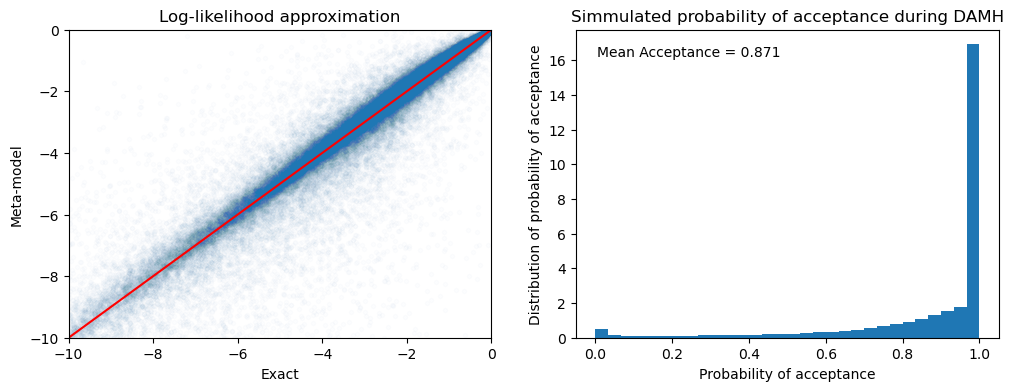

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polynomial_regression(X, y, degree):
    # Create a pipeline that first creates polynomial features and then fits a linear regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    return model

tmp = polynomial_regression(X_train, y_train, 5)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)


Degree:  3


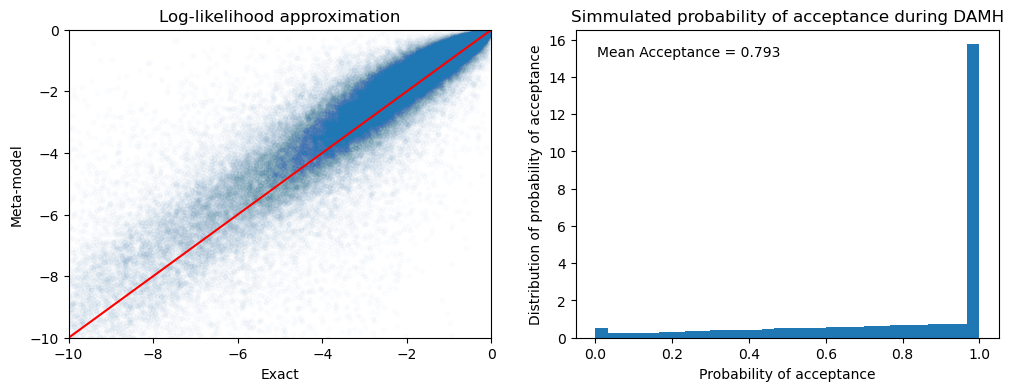

Degree:  4


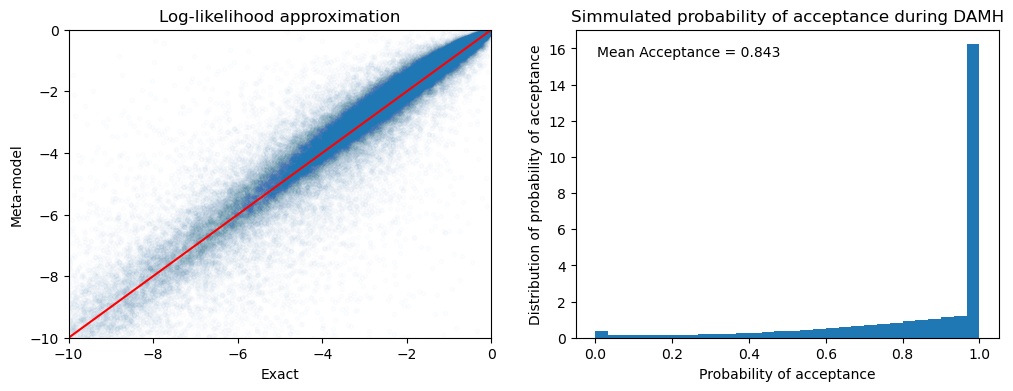

Degree:  5


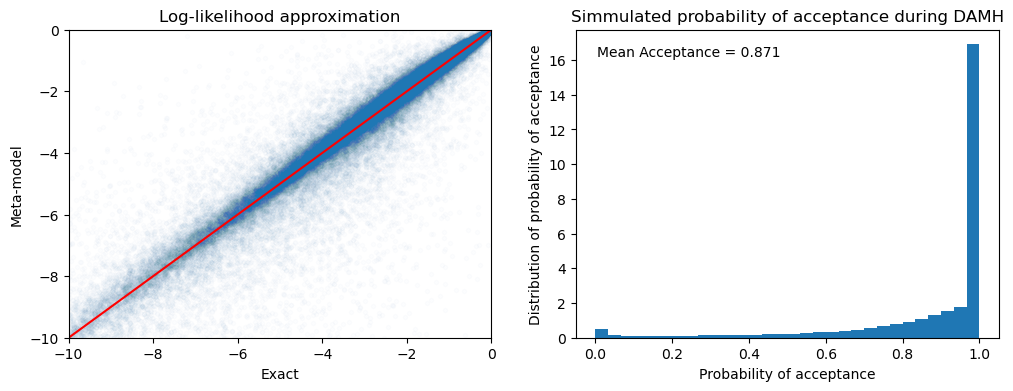

Degree:  6


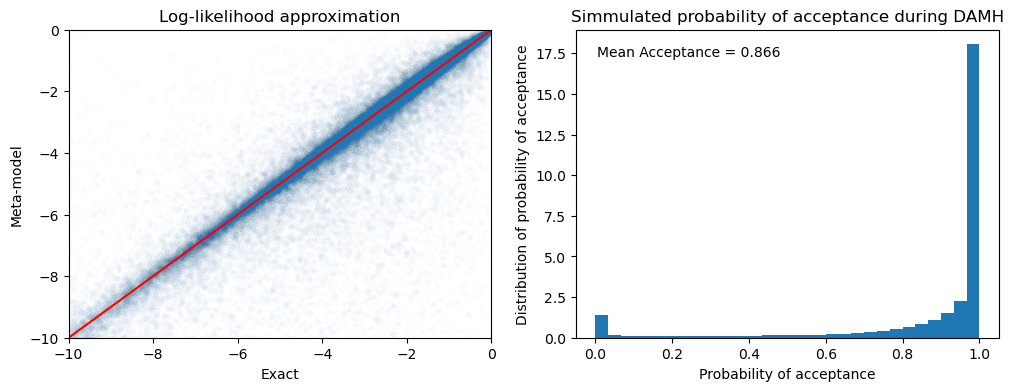

Degree:  7


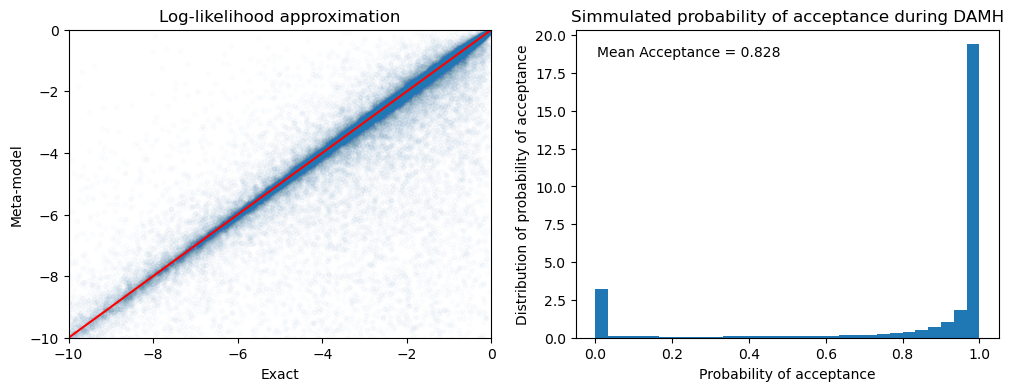

In [13]:

for degree in range(3, 8):
    print("Degree: ", degree)
    tmp = polynomial_regression(X_train, y_train, degree)
    res_surr = tmp.predict(X_test)

    # compute alphas and plot results
    plot_results_all(res_surr)


## RBF pomocí scipy

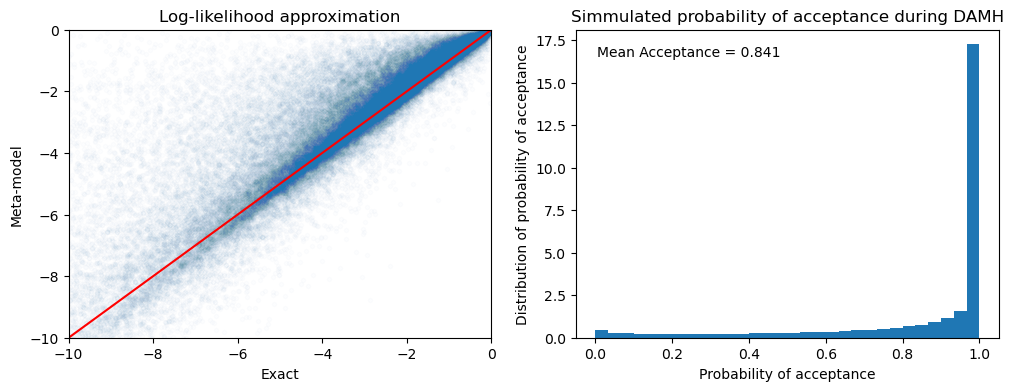

In [14]:
from scipy.interpolate import RBFInterpolator

# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
tmp = RBFInterpolator(X_train, y_train, kernel='linear', smoothing=1e-9)
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

## více typů RBF v scipy
obdobná implementace, ale scipy je rychlejší

Kernel: linear


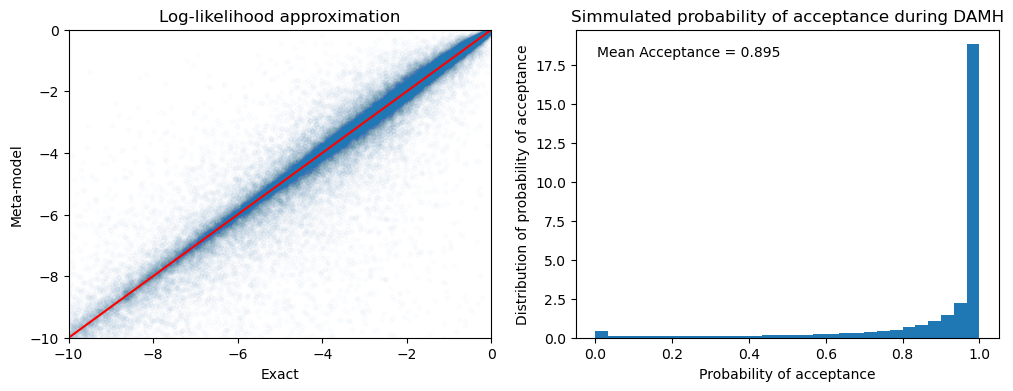

Kernel: thin_plate_spline


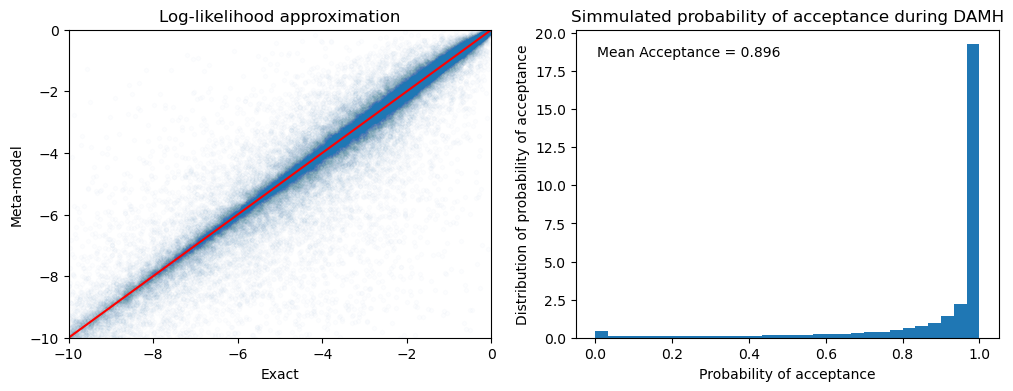

Kernel: cubic


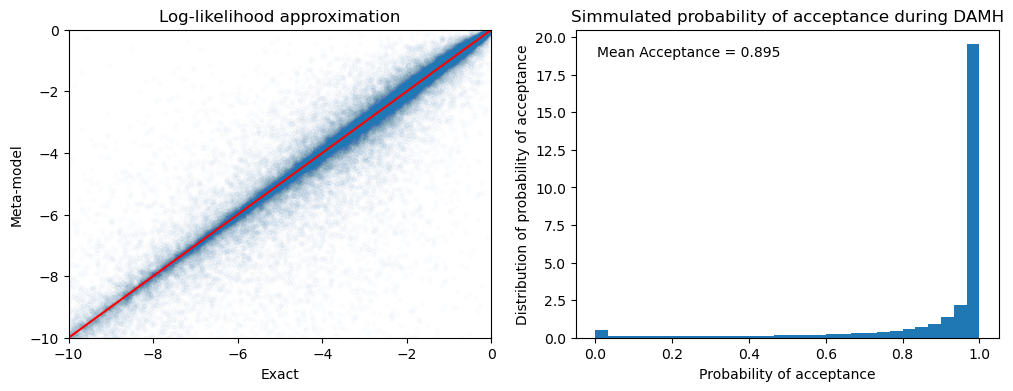

In [15]:
# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
from math import e


list_kernels = ['linear', 'thin_plate_spline', 'cubic']


for type_kernel in list_kernels:
    print(f"Kernel: {type_kernel}")
    tmp = RBFInterpolator(X_train, y_train, kernel=type_kernel, smoothing=1e-9, degree=5, epsilon=1e-1)
    res_surr = tmp(X_test)
    # compute alphas and plot results
    plot_results_all(res_surr)

# Zkouška pomocí neural network v sklearn

Iteration 1, loss = 782.77887287
Iteration 2, loss = 90.35431792
Iteration 3, loss = 78.01430855
Iteration 4, loss = 61.44486111
Iteration 5, loss = 43.16927400
Iteration 6, loss = 29.40543769
Iteration 7, loss = 23.85863596
Iteration 8, loss = 20.72921070
Iteration 9, loss = 18.37676687
Iteration 10, loss = 16.91412086
Iteration 11, loss = 16.04104610
Iteration 12, loss = 15.62510983
Iteration 13, loss = 14.42178356
Iteration 14, loss = 14.43823885
Iteration 15, loss = 13.83106715
Iteration 16, loss = 13.40275508
Iteration 17, loss = 13.16097619
Iteration 18, loss = 13.07378630
Iteration 19, loss = 12.59262259
Iteration 20, loss = 12.94295486
Iteration 21, loss = 12.43401620
Iteration 22, loss = 12.55305851
Iteration 23, loss = 11.71944476
Iteration 24, loss = 11.96427152
Iteration 25, loss = 11.89673464
Iteration 26, loss = 11.51039493
Iteration 27, loss = 11.52786699
Iteration 28, loss = 11.11485592
Iteration 29, loss = 11.39122125
Iteration 30, loss = 10.95020253
Iteration 31, loss

/usr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


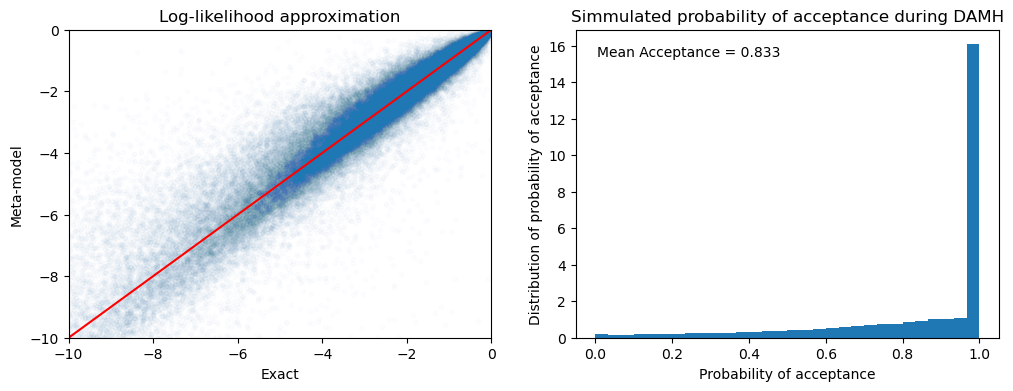

In [21]:
from sklearn.neural_network import MLPRegressor

# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(50,),activation='relu', solver='adam', max_iter=50000, verbose=True, n_iter_no_change=10000, 
                   learning_rate_init=0.1)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 2768.32494657
Iteration 2, loss = 221.67799206
Iteration 3, loss = 106.03322648
Iteration 4, loss = 97.30208955
Iteration 5, loss = 93.42176672
Iteration 6, loss = 90.85275649
Iteration 7, loss = 88.13935851
Iteration 8, loss = 85.96155866
Iteration 9, loss = 83.75175378
Iteration 10, loss = 81.31250677
Iteration 11, loss = 78.62775685
Iteration 12, loss = 75.55923178
Iteration 13, loss = 72.26968289
Iteration 14, loss = 68.85010182
Iteration 15, loss = 64.98325313
Iteration 16, loss = 61.24613077
Iteration 17, loss = 57.26248358
Iteration 18, loss = 53.23388883
Iteration 19, loss = 48.75963066
Iteration 20, loss = 43.51562345
Iteration 21, loss = 38.18131107
Iteration 22, loss = 32.95809233
Iteration 23, loss = 28.13938616
Iteration 24, loss = 24.18397760
Iteration 25, loss = 20.98521683
Iteration 26, loss = 18.58608520
Iteration 27, loss = 16.89581416
Iteration 28, loss = 15.77080598
Iteration 29, loss = 14.77964825
Iteration 30, loss = 13.99293184
Iteration 31, l

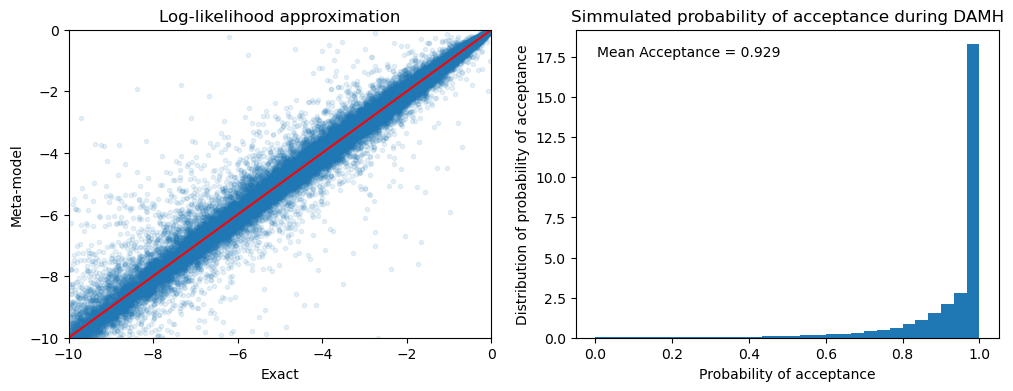

In [94]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(500,500),activation='relu', solver='adam', max_iter=50000, verbose=True, n_iter_no_change=100)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 1495.76244353
Iteration 2, loss = 100.93353303
Iteration 3, loss = 93.05745310
Iteration 4, loss = 90.06179825
Iteration 5, loss = 87.12611858
Iteration 6, loss = 83.34975215
Iteration 7, loss = 78.36216901
Iteration 8, loss = 73.17055250
Iteration 9, loss = 68.41299170
Iteration 10, loss = 64.71810406
Iteration 11, loss = 61.32748703
Iteration 12, loss = 58.39737479
Iteration 13, loss = 55.03865710
Iteration 14, loss = 50.67393970
Iteration 15, loss = 44.00923262
Iteration 16, loss = 35.73524654
Iteration 17, loss = 28.26955604
Iteration 18, loss = 21.93380329
Iteration 19, loss = 15.54498410
Iteration 20, loss = 11.66069637
Iteration 21, loss = 9.91251782
Iteration 22, loss = 8.56534303
Iteration 23, loss = 7.89598789
Iteration 24, loss = 7.37284928
Iteration 25, loss = 7.05720674
Iteration 26, loss = 6.38711354
Iteration 27, loss = 6.05097442
Iteration 28, loss = 5.89675105
Iteration 29, loss = 5.62677436
Iteration 30, loss = 5.41381104
Iteration 31, loss = 5.131

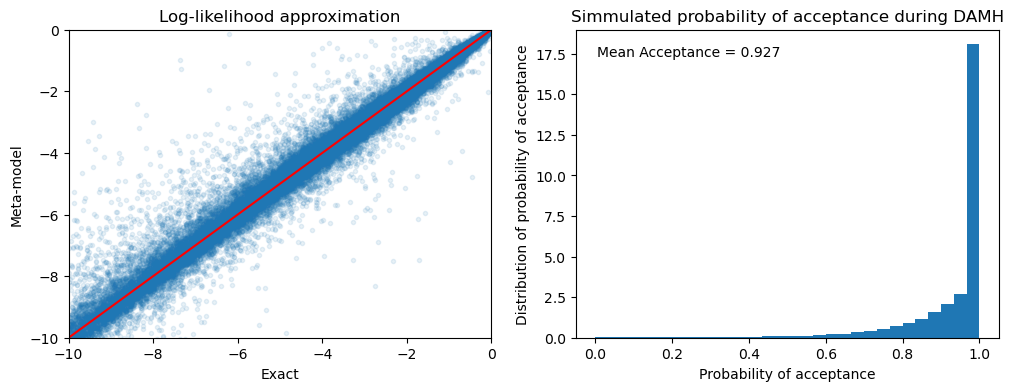

In [93]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(500,500,500),activation='relu', solver='adam', max_iter=50000, verbose=True, n_iter_no_change=200)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 1399.80698066
Iteration 2, loss = 100.91882641
Iteration 3, loss = 91.93734826
Iteration 4, loss = 86.73554290
Iteration 5, loss = 81.12166343
Iteration 6, loss = 74.91402797
Iteration 7, loss = 67.97393746
Iteration 8, loss = 60.31735909
Iteration 9, loss = 52.40602714
Iteration 10, loss = 43.43285639
Iteration 11, loss = 33.34480497
Iteration 12, loss = 24.54492966
Iteration 13, loss = 18.46440771
Iteration 14, loss = 15.03146535
Iteration 15, loss = 12.86895028
Iteration 16, loss = 11.04475531
Iteration 17, loss = 9.95752389
Iteration 18, loss = 9.10527014
Iteration 19, loss = 8.32570961
Iteration 20, loss = 7.70729789
Iteration 21, loss = 7.31591530
Iteration 22, loss = 6.67402385
Iteration 23, loss = 6.42555251
Iteration 24, loss = 6.05997761
Iteration 25, loss = 5.65082795
Iteration 26, loss = 5.40166116
Iteration 27, loss = 5.19475921
Iteration 28, loss = 4.80854558
Iteration 29, loss = 4.65978139
Iteration 30, loss = 4.51643689
Iteration 31, loss = 4.3071188

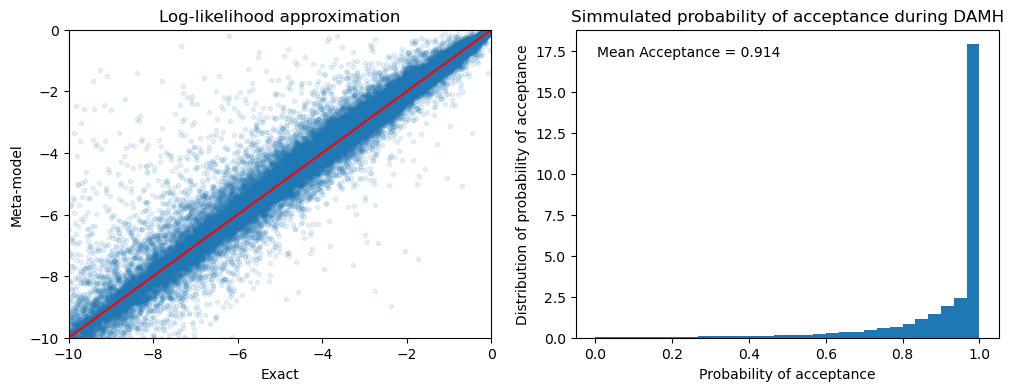

In [91]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(2000,2000),activation='relu', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 976.71486612
Iteration 2, loss = 95.28671591
Iteration 3, loss = 89.20388924
Iteration 4, loss = 83.59183372
Iteration 5, loss = 75.66374933
Iteration 6, loss = 65.96190624
Iteration 7, loss = 56.67779145
Iteration 8, loss = 47.33279973
Iteration 9, loss = 36.31673833
Iteration 10, loss = 24.67066102
Iteration 11, loss = 16.55818422
Iteration 12, loss = 12.45462081
Iteration 13, loss = 10.09175991
Iteration 14, loss = 8.81596972
Iteration 15, loss = 7.88945606
Iteration 16, loss = 7.14238174
Iteration 17, loss = 6.49083957
Iteration 18, loss = 6.07193255
Iteration 19, loss = 5.63872353
Iteration 20, loss = 5.13032708
Iteration 21, loss = 4.89447064
Iteration 22, loss = 4.58838800
Iteration 23, loss = 4.51646625
Iteration 24, loss = 4.46655301
Iteration 25, loss = 3.88995857
Iteration 26, loss = 3.68715607
Iteration 27, loss = 3.46176987
Iteration 28, loss = 3.30485463
Iteration 29, loss = 3.16095692
Iteration 30, loss = 3.14951378
Iteration 31, loss = 2.84334062
Ite

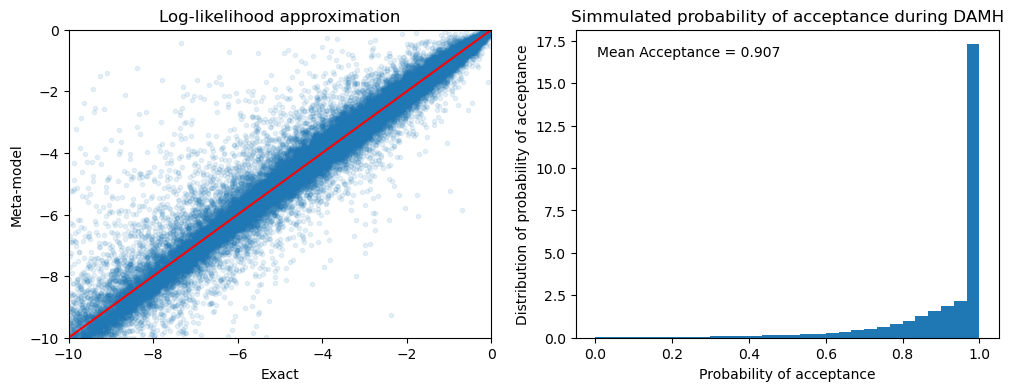

In [92]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(4000,4000),activation='relu', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

# pytorch


Using cuda device
Iteration 0, Loss: 8914.98046875, Learning rate: 0.1.
Iteration 10000, Loss: 2.0273451805114746, Learning rate: 0.1.
Iteration 20000, Loss: 3.9312713146209717, Learning rate: 0.1.
Iteration 30000, Loss: 1.5169498920440674, Learning rate: 0.1.
Iteration 40000, Loss: 1.6799969673156738, Learning rate: 0.1.
Iteration 50000, Loss: 2.208296537399292, Learning rate: 0.1.
Iteration 60000, Loss: 1.0183008909225464, Learning rate: 0.1.
Iteration 70000, Loss: 2.408890962600708, Learning rate: 0.1.
Iteration 80000, Loss: 1.1519043445587158, Learning rate: 0.1.
Iteration 90000, Loss: 1.6174103021621704, Learning rate: 0.1.
Iteration 100000, Loss: 1.5323716402053833, Learning rate: 0.1.
Iteration 110000, Loss: 1.1165399551391602, Learning rate: 0.1.
Iteration 120000, Loss: 1.3544700145721436, Learning rate: 0.1.
Iteration 130000, Loss: 0.9085931777954102, Learning rate: 0.05.
Iteration 140000, Loss: 0.8869619369506836, Learning rate: 0.05.
Iteration 150000, Loss: 1.035282611846923

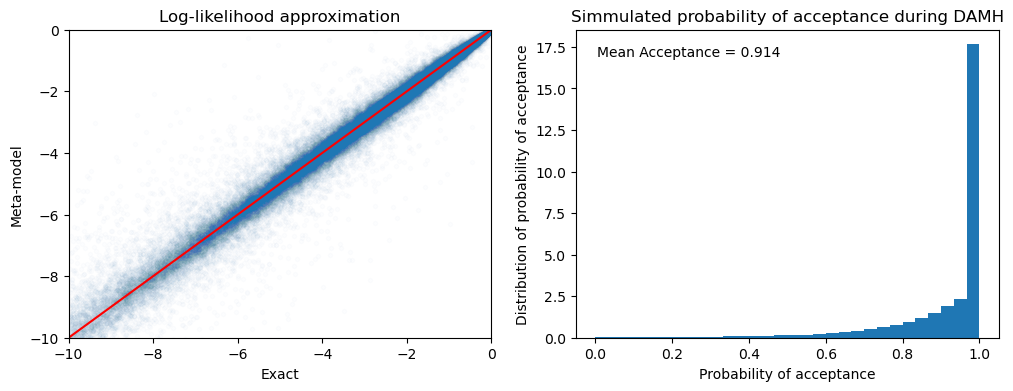

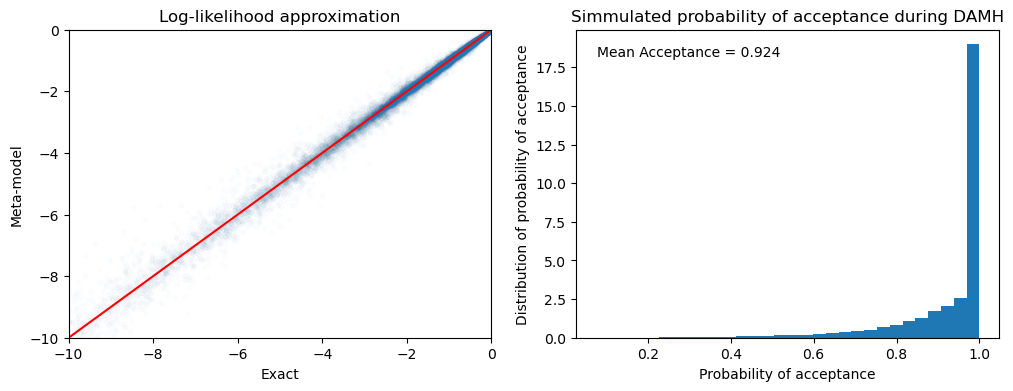

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 50
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25000, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Step 5: Train the Model
max_iter = 1000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if iteration % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


In [30]:
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap
from flax import linen as nn
import optax
import numpy as np

n_lyer = 10

# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def setup(self):
        self.layer1 = nn.Dense(n_lyer)
        self.layer2 = nn.Dense(n_lyer)
        self.layer3 = nn.Dense(n_lyer)
        self.layer4 = nn.Dense(y_train.shape[1])

    def __call__(self, x):
        x = nn.tanh(self.layer1(x))
        x = nn.tanh(self.layer2(x))
        x = nn.tanh(self.layer3(x))
        return self.layer4(x)

# Step 2: Initialize Parameters
key = random.PRNGKey(0)
input_shape = (1, X_train.shape[1])
initial_params = MLPRegressor().init(key, jnp.ones(input_shape))

# Define optimizer
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(initial_params)

# Step 3: Define a Loss Function
def mse_loss(params, inputs, targets):
    predictions = MLPRegressor().apply(params, inputs)
    return jnp.mean((predictions - targets) ** 2)

@jit
def train_step(params, opt_state, X, y):
    def loss_fn(params):
        return mse_loss(params, X, y)
    for i in range(1000):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# Step 4: Convert Numpy Data to JAX Device Arrays
X_train_device = jnp.array(X_train, dtype=jnp.float32)
y_train_device = jnp.array(y_train, dtype=jnp.float32)

# Step 5: Train the Model
max_iter = 1000000
lr_patience = 25
lr_factor = 0.5
stagnant_count = 0
prev_loss = float('inf')
print(f'Starting...')

for iteration in range(max_iter):
    initial_params, opt_state, loss_val = train_step(initial_params, opt_state, X_train_device, y_train_device)

    # Learning rate scheduling
    if loss_val >= prev_loss:
        stagnant_count += 1
        if stagnant_count >= lr_patience:
            print(f'Learning rate reduced to {learning_rate * lr_factor}')
            learning_rate *= lr_factor
            optimizer = optax.chain(optax.scale_by_adam(), optax.scale(-learning_rate))
            opt_state = optimizer.init(initial_params)
            stagnant_count = 0
    else:
        stagnant_count = 0
    prev_loss = min(loss_val, prev_loss)


    print(f'Iteration {iteration}, Loss: {loss_val}, Learning rate: {learning_rate}')

# Step 6: Test the Model
X_test_device = jnp.array(X_test, dtype=jnp.float32)
res_surr = MLPRegressor().apply(initial_params, X_test_device)

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_train_device_test = jnp.array(X_train, dtype=jnp.float32)
res_surr_train = MLPRegressor().apply(initial_params, X_train_device_test)

# Step 7: Plot the Results
# Replace 'plot_results_all_train' with your own plotting function
plot_results_all_train(res_surr_train)


Starting...


Using cuda device
Iteration 0, Loss: 8920.474609375, Learning rate: 0.1.
Iteration 10000, Loss: 1.771105170249939, Learning rate: 0.1.
Iteration 20000, Loss: 2.0088865756988525, Learning rate: 0.1.
Iteration 30000, Loss: 1.1404142379760742, Learning rate: 0.1.
Iteration 40000, Loss: 0.6496098041534424, Learning rate: 0.1.
Iteration 50000, Loss: 0.4843115210533142, Learning rate: 0.1.
Iteration 60000, Loss: 0.5612136721611023, Learning rate: 0.1.
Iteration 70000, Loss: 1.5787701606750488, Learning rate: 0.1.
Iteration 80000, Loss: 0.3308391869068146, Learning rate: 0.05.
Iteration 90000, Loss: 0.2647775411605835, Learning rate: 0.05.
Iteration 100000, Loss: 0.2241268754005432, Learning rate: 0.05.
Iteration 110000, Loss: 0.6001577377319336, Learning rate: 0.05.
Iteration 120000, Loss: 0.21771633625030518, Learning rate: 0.05.
Iteration 130000, Loss: 0.21989881992340088, Learning rate: 0.05.
Iteration 140000, Loss: 0.24676913022994995, Learning rate: 0.05.
Iteration 150000, Loss: 0.24537

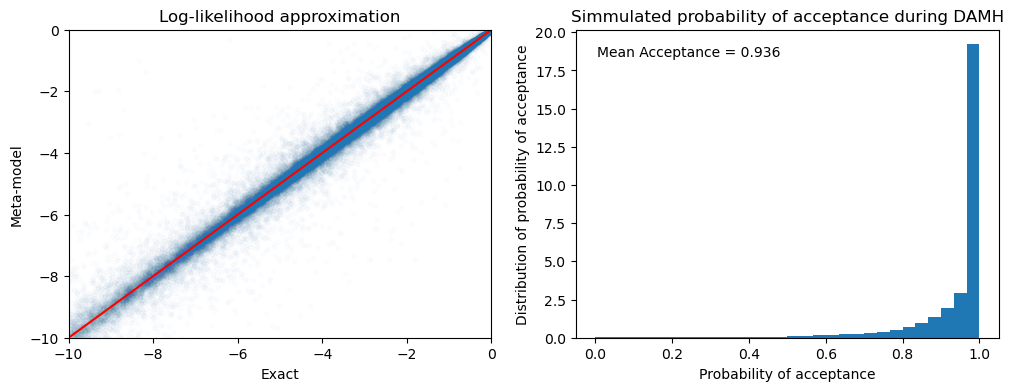

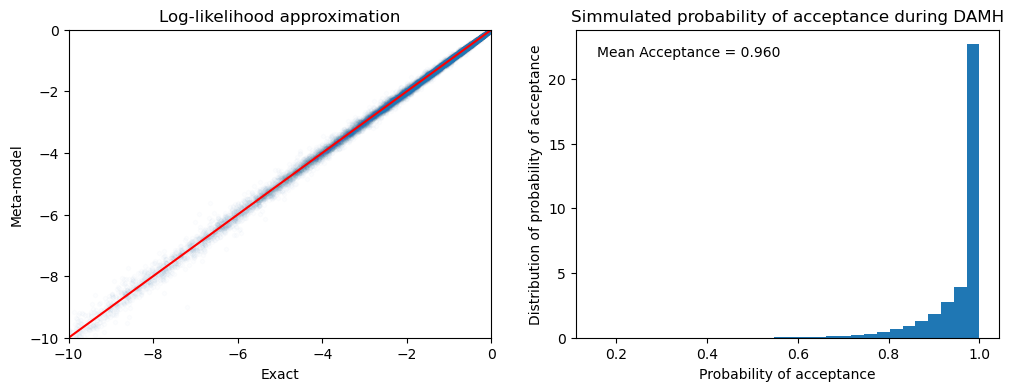

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 100
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10000, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 1000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if iteration % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


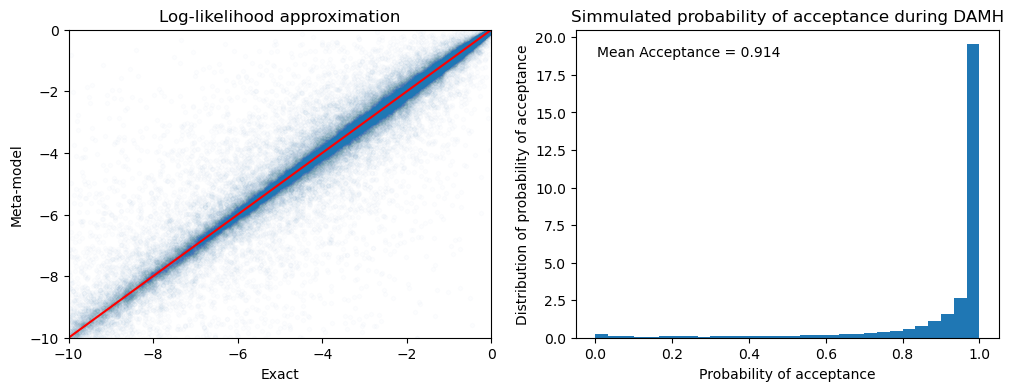

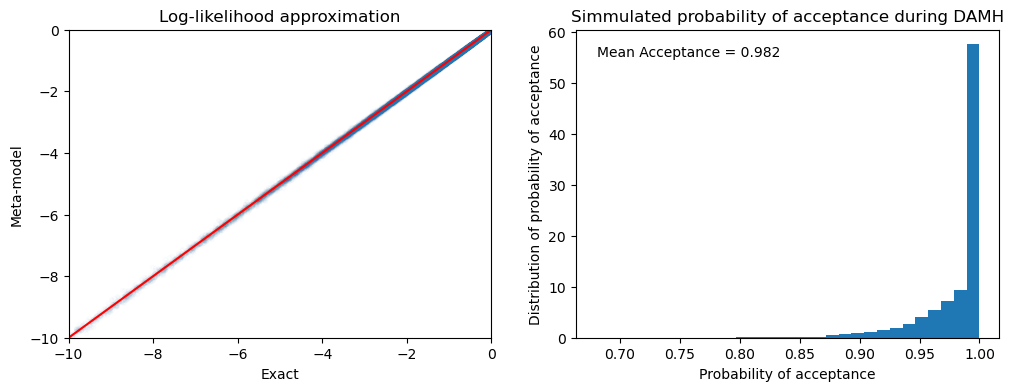

In [30]:
# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)

Using cuda device
Iteration 0, Loss: 8927.4990234375, Learning rate: 0.1.
Iteration 10000, Loss: 3.8697006702423096, Learning rate: 0.1.
Iteration 20000, Loss: 1.719102144241333, Learning rate: 0.1.
Iteration 30000, Loss: 1.7286275625228882, Learning rate: 0.1.
Iteration 40000, Loss: 2.001840114593506, Learning rate: 0.1.
Iteration 50000, Loss: 0.9249410033226013, Learning rate: 0.1.
Iteration 60000, Loss: 1.1919866800308228, Learning rate: 0.1.
Iteration 70000, Loss: 2.298129081726074, Learning rate: 0.1.
Iteration 80000, Loss: 0.9873926639556885, Learning rate: 0.1.
Iteration 90000, Loss: 0.673881471157074, Learning rate: 0.1.
Iteration 100000, Loss: 1.2851953506469727, Learning rate: 0.1.
Iteration 110000, Loss: 0.7188705801963806, Learning rate: 0.1.
Iteration 120000, Loss: 1.2242141962051392, Learning rate: 0.1.
Iteration 130000, Loss: 0.9609241485595703, Learning rate: 0.1.
Iteration 140000, Loss: 0.5006216168403625, Learning rate: 0.05.
Iteration 150000, Loss: 0.4575590491294861

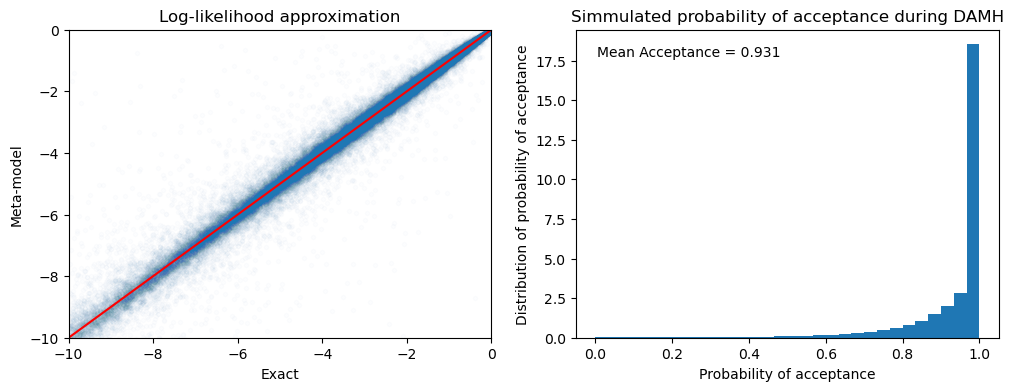

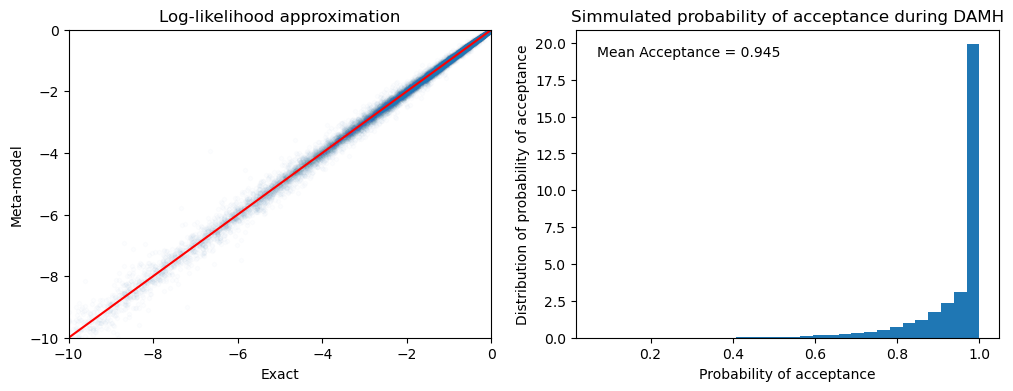

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 50
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10000, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 1000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if iteration % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


Using cuda device
Iteration 9999, Loss: 3.469257354736328, Learning rate: 0.1.
Iteration 19999, Loss: 0.6571286916732788, Learning rate: 0.1.
Iteration 29999, Loss: 2.9814839363098145, Learning rate: 0.1.
Iteration 39999, Loss: 0.7998073697090149, Learning rate: 0.1.
Iteration 49999, Loss: 1.9821394681930542, Learning rate: 0.1.
Iteration 59999, Loss: 1.0102118253707886, Learning rate: 0.1.
Iteration 69999, Loss: 0.5592145323753357, Learning rate: 0.1.
Iteration 79999, Loss: 0.519170880317688, Learning rate: 0.1.
Iteration 89999, Loss: 0.5075013041496277, Learning rate: 0.1.
Iteration 99999, Loss: 0.631547212600708, Learning rate: 0.1.
Iteration 109999, Loss: 0.3776395320892334, Learning rate: 0.1.
Iteration 119999, Loss: 0.4763723611831665, Learning rate: 0.1.
Iteration 129999, Loss: 0.424678772687912, Learning rate: 0.1.
Iteration 139999, Loss: 1.1114548444747925, Learning rate: 0.1.
Iteration 149999, Loss: 0.25615251064300537, Learning rate: 0.05.
Iteration 159999, Loss: 0.242757052

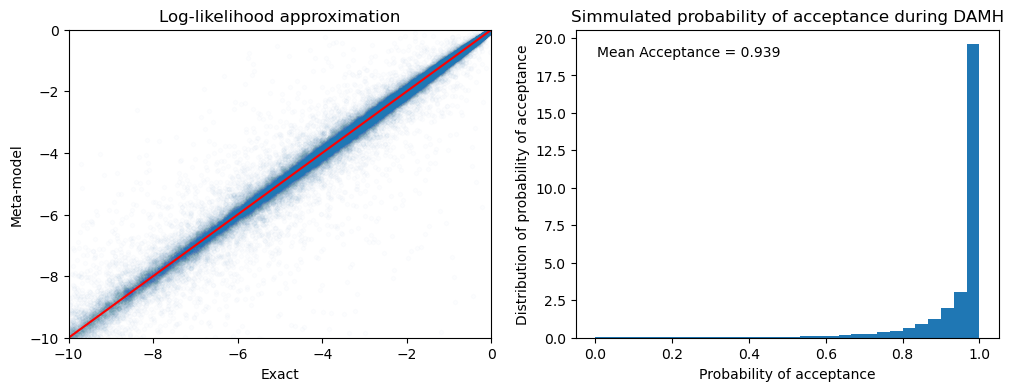

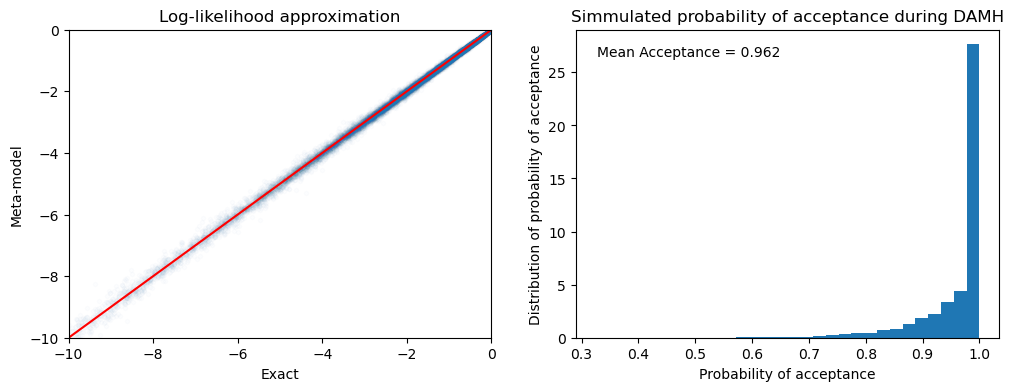

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 100
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30000, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 2000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if (iteration + 1) % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


Using cuda device
Iteration 9999, Loss: 13.754453659057617, Learning rate: 0.01.
Iteration 19999, Loss: 3.598520517349243, Learning rate: 0.01.
Iteration 29999, Loss: 1.4118189811706543, Learning rate: 0.01.
Iteration 39999, Loss: 1.1244100332260132, Learning rate: 0.01.
Iteration 49999, Loss: 0.851433515548706, Learning rate: 0.01.
Iteration 59999, Loss: 0.8976921439170837, Learning rate: 0.01.
Iteration 69999, Loss: 0.7869457006454468, Learning rate: 0.01.
Iteration 79999, Loss: 1.647215485572815, Learning rate: 0.01.
Iteration 89999, Loss: 0.5987128019332886, Learning rate: 0.01.
Iteration 99999, Loss: 0.41401979327201843, Learning rate: 0.01.
Iteration 109999, Loss: 0.7326604723930359, Learning rate: 0.01.
Iteration 119999, Loss: 0.5983816981315613, Learning rate: 0.01.
Iteration 129999, Loss: 0.4850129187107086, Learning rate: 0.01.
Iteration 139999, Loss: 0.46543726325035095, Learning rate: 0.01.
Iteration 149999, Loss: 0.848931074142456, Learning rate: 0.01.
Iteration 159999, Lo

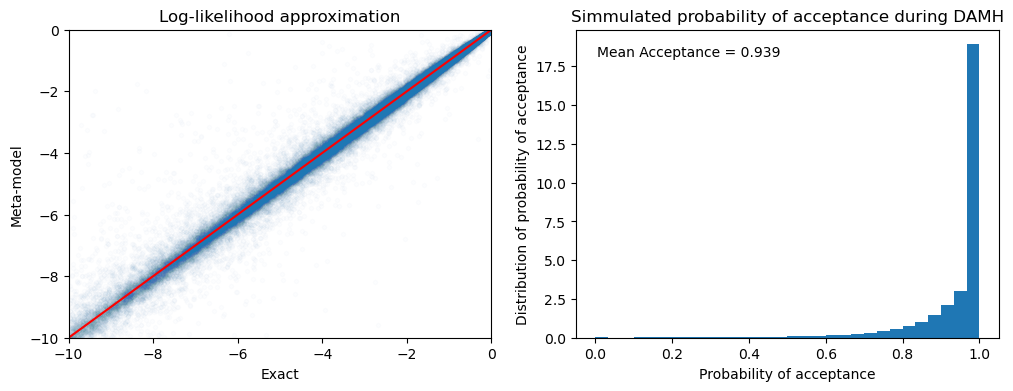

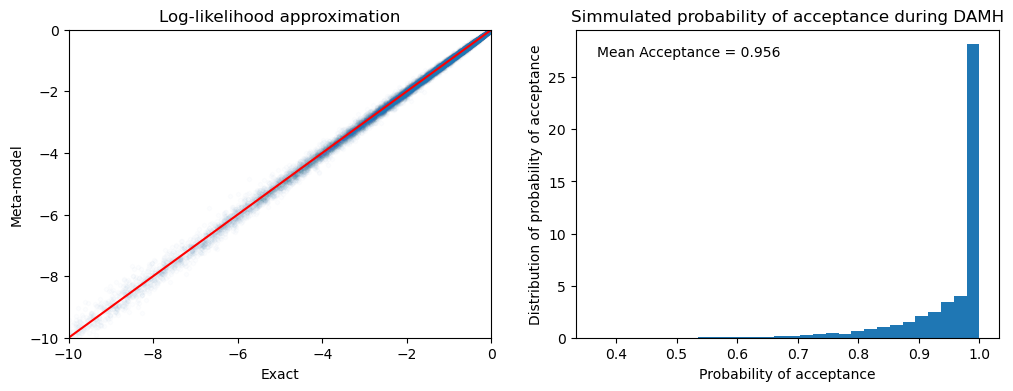

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 50
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20000, factor=0.75)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 2000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if (iteration + 1) % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


Iteration 0, Loss: 1.0779094696044922, Learning rate: 0.1.
Iteration 10000, Loss: 1.6216926574707031, Learning rate: 0.1.
Iteration 20000, Loss: 1.1246042251586914, Learning rate: 0.1.
Iteration 30000, Loss: 0.9629116654396057, Learning rate: 0.1.
Iteration 40000, Loss: 0.7781292200088501, Learning rate: 0.1.
Iteration 50000, Loss: 1.0071660280227661, Learning rate: 0.1.
Iteration 60000, Loss: 0.7449140548706055, Learning rate: 0.1.
Iteration 70000, Loss: 1.8543059825897217, Learning rate: 0.1.
Iteration 80000, Loss: 0.8551756739616394, Learning rate: 0.05.
Iteration 90000, Loss: 0.691223680973053, Learning rate: 0.05.
Iteration 100000, Loss: 0.6233011484146118, Learning rate: 0.05.
Iteration 110000, Loss: 0.6409013271331787, Learning rate: 0.05.
Iteration 120000, Loss: 0.6381543874740601, Learning rate: 0.05.
Iteration 130000, Loss: 0.5801056623458862, Learning rate: 0.05.
Iteration 140000, Loss: 0.5527641177177429, Learning rate: 0.05.
Iteration 150000, Loss: 0.6561598777770996, Lear

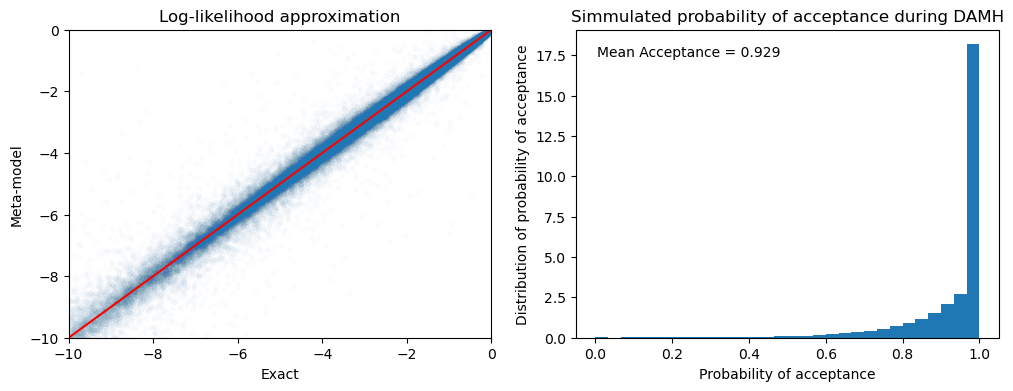

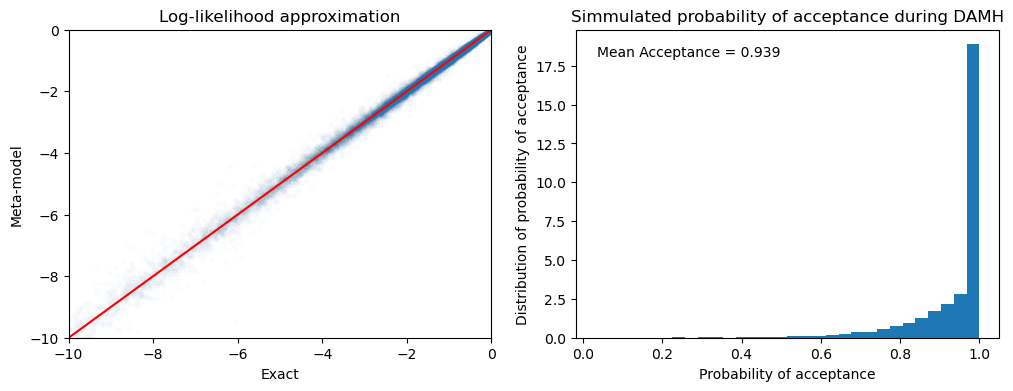

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20000, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 1000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if iteration % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 250
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20000, factor=0.75)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 2000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if (iteration + 1) % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


Using cuda device
Iteration 9999, Loss: 0.45734506845474243, Learning rate: 0.01.
Iteration 19999, Loss: 0.3176345229148865, Learning rate: 0.01.
Iteration 29999, Loss: 0.13018469512462616, Learning rate: 0.01.
Iteration 39999, Loss: 0.06766729801893234, Learning rate: 0.01.
Iteration 49999, Loss: 0.07630323618650436, Learning rate: 0.01.
Iteration 59999, Loss: 0.02026502415537834, Learning rate: 0.01.
Iteration 69999, Loss: 0.01620841585099697, Learning rate: 0.01.
Iteration 79999, Loss: 0.028326382860541344, Learning rate: 0.01.
Iteration 89999, Loss: 0.018060611560940742, Learning rate: 0.01.
Iteration 99999, Loss: 0.01180898305028677, Learning rate: 0.01.
Iteration 109999, Loss: 0.014186128042638302, Learning rate: 0.01.
Iteration 119999, Loss: 0.19896525144577026, Learning rate: 0.01.
Iteration 129999, Loss: 0.010240437462925911, Learning rate: 0.01.
Iteration 139999, Loss: 0.009699076414108276, Learning rate: 0.01.
Iteration 149999, Loss: 0.00877500232309103, Learning rate: 0.01.

KeyboardInterrupt: 

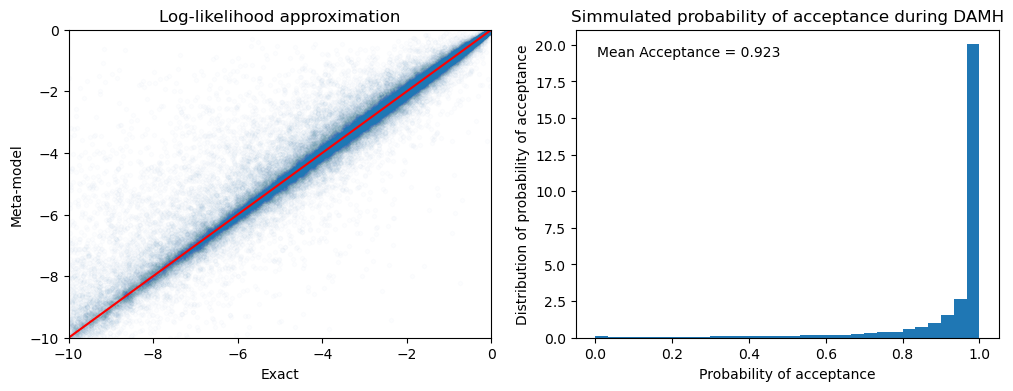

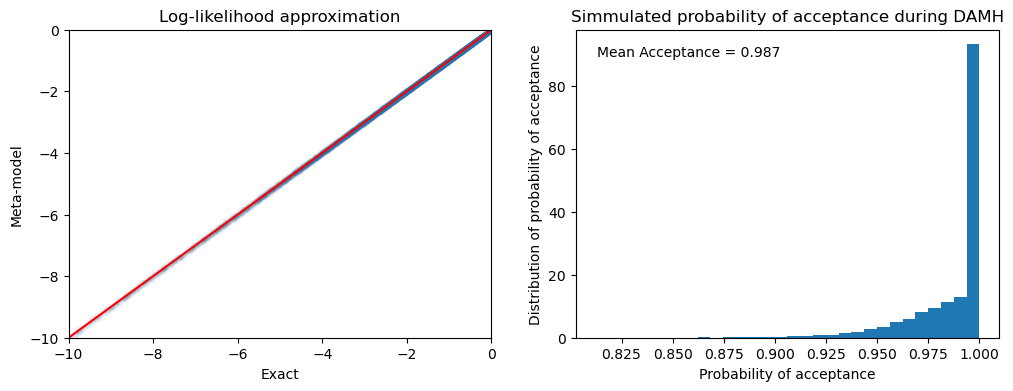

In [13]:
# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


Using cuda device
Iteration 9999, Loss: 0.8459591269493103, Learning rate: 0.01.
Iteration 19999, Loss: 0.3601507842540741, Learning rate: 0.01.
Iteration 29999, Loss: 2.9416751861572266, Learning rate: 0.01.
Iteration 39999, Loss: 0.33742812275886536, Learning rate: 0.01.
Iteration 49999, Loss: 1.5876375436782837, Learning rate: 0.01.
Iteration 59999, Loss: 0.5165538787841797, Learning rate: 0.01.
Iteration 69999, Loss: 2.2891135215759277, Learning rate: 0.01.
Iteration 79999, Loss: 0.4195012152194977, Learning rate: 0.01.
Iteration 89999, Loss: 0.18121148645877838, Learning rate: 0.01.
Iteration 99999, Loss: 0.06815837323665619, Learning rate: 0.01.
Iteration 109999, Loss: 0.2366228550672531, Learning rate: 0.01.
Iteration 119999, Loss: 0.15731865167617798, Learning rate: 0.01.
Iteration 129999, Loss: 0.07742723077535629, Learning rate: 0.01.
Iteration 139999, Loss: 0.21953094005584717, Learning rate: 0.01.
Iteration 149999, Loss: 0.15730872750282288, Learning rate: 0.01.
Iteration 1

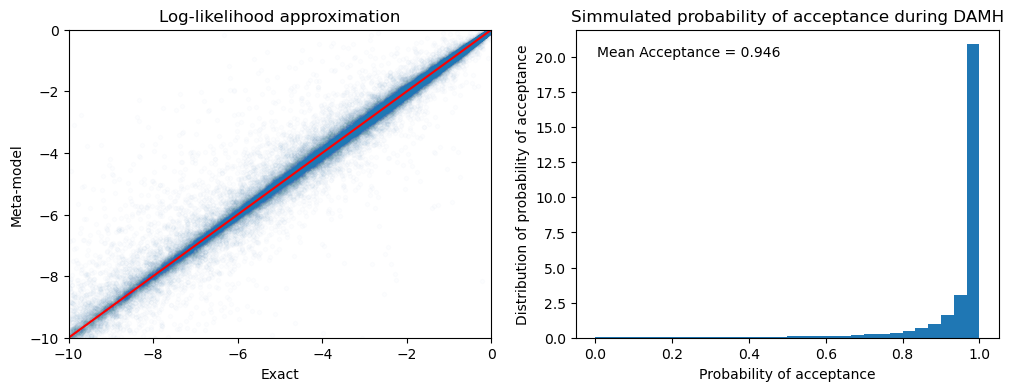

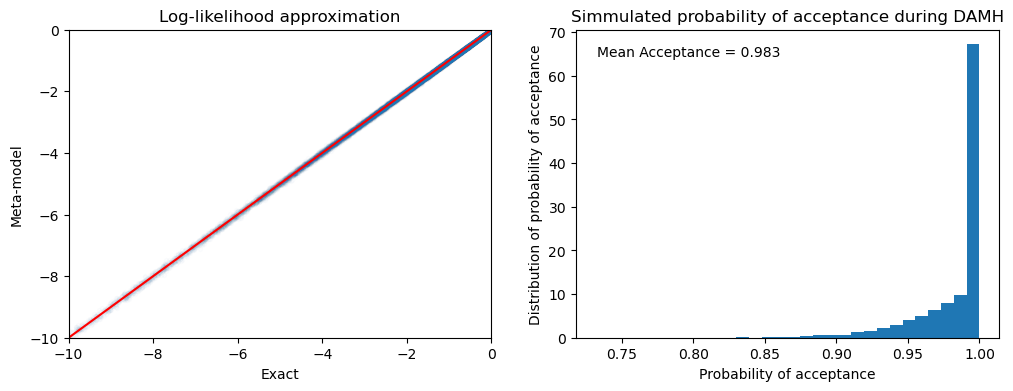

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 100
# Step 1: Define the Neural Network Architecture
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),            
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)
    
# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20000, factor=0.75)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

break_the_loop = False

# Step 5: Train the Model
max_iter = 2000000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if (iteration + 1) % 10000 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, ', end='')
        # print current learning rate
        for param_group in optimizer.param_groups:
            print(f'Learning rate: {param_group["lr"]}', end='')
            if param_group['lr'] < 1e-4:
                print(" (STOP)")
                break_the_loop = True
        if break_the_loop:
            break
        print(".")
        

# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)


In [ ]:
# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all(res_surr)

X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)

Using cuda device
Epoch [1/50000], Loss: 6588.7754, min Loss reached inf, stagnating for 0 it.
Epoch [2/50000], Loss: 2944.1975, min Loss reached 6588.7754, stagnating for 0 it.
Epoch [3/50000], Loss: 556.9185, min Loss reached 2944.1975, stagnating for 0 it.
Epoch [4/50000], Loss: 343.7981, min Loss reached 556.9185, stagnating for 0 it.
Epoch [5/50000], Loss: 227.2619, min Loss reached 343.7981, stagnating for 0 it.
Epoch [6/50000], Loss: 194.9692, min Loss reached 227.2619, stagnating for 0 it.
Epoch [7/50000], Loss: 193.9568, min Loss reached 194.9692, stagnating for 0 it.
Epoch [8/50000], Loss: 169.6842, min Loss reached 193.9568, stagnating for 0 it.
Epoch [9/50000], Loss: 171.7085, min Loss reached 169.6842, stagnating for 0 it.
Epoch [10/50000], Loss: 163.9919, min Loss reached 169.6842, stagnating for 1 it.
Epoch [11/50000], Loss: 149.3323, min Loss reached 163.9919, stagnating for 0 it.
Epoch [12/50000], Loss: 141.5799, min Loss reached 149.3323, stagnating for 0 it.
Epoch [1

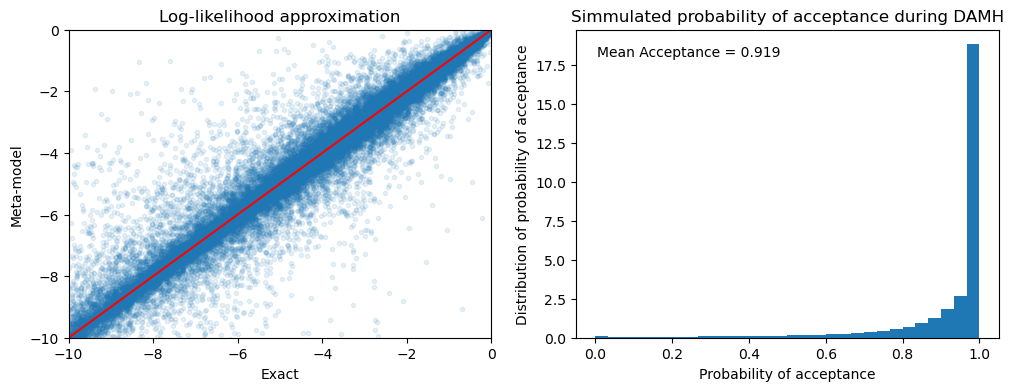

In [55]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Creating a simple neural network in PyTorch

n_lyer = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, n_lyer),
            nn.ReLU(),
            nn.Linear(n_lyer, y_train.shape[1])
        )
        
    def forward(self, x):
        return self.layers(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
# Create the model
model = Net().to(device)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Create DataLoader for the training set
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)  # Adjust the batch size



# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Decrease the learning rate

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.8)

# Train the model
num_epochs = 50000
best_loss = np.inf
patience, trials = 1000, 0

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust the learning rate based on the loss
    scheduler.step(loss)

    print('Epoch [{}/{}], Loss: {:.4f}, min Loss reached {:.4f}, stagnating for {} it.'.format(epoch + 1, num_epochs, loss.item(), best_loss, trials))

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f'Stopping early at epoch {epoch+1}')
            break

# Test the model
model.eval()
with torch.no_grad():
    res_surr = model(X_test_tensor).detach().cpu().numpy()


# Compute alphas and plot results
plot_results_all(res_surr)


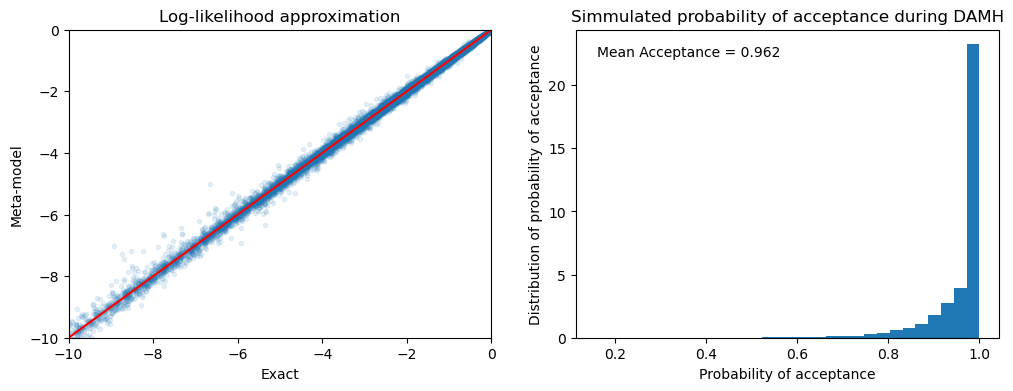

In [56]:
X_test_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()

# Step 7: Plot the Results
# Replace 'plot_results_all' with your own plotting function
plot_results_all_train(res_surr)

Epoch [1/50000], Loss: 350.7386, min Loss reached inf, stagnating for 0 it.
Epoch [2/50000], Loss: 263.3156, min Loss reached 350.7386, stagnating for 0 it.
Epoch [3/50000], Loss: 190.1109, min Loss reached 263.3156, stagnating for 0 it.
Epoch [4/50000], Loss: 67.9098, min Loss reached 190.1109, stagnating for 0 it.
Epoch [5/50000], Loss: 64.8409, min Loss reached 67.9098, stagnating for 0 it.
Epoch [6/50000], Loss: 35.5689, min Loss reached 64.8409, stagnating for 0 it.
Epoch [7/50000], Loss: 25.0407, min Loss reached 35.5689, stagnating for 0 it.
Epoch [8/50000], Loss: 26.8246, min Loss reached 25.0407, stagnating for 0 it.
Epoch [9/50000], Loss: 41.1813, min Loss reached 25.0407, stagnating for 1 it.
Epoch [10/50000], Loss: 19.6068, min Loss reached 25.0407, stagnating for 2 it.
Epoch [11/50000], Loss: 26.2592, min Loss reached 19.6068, stagnating for 0 it.
Epoch [12/50000], Loss: 52.5328, min Loss reached 19.6068, stagnating for 1 it.
Epoch [13/50000], Loss: 32.0407, min Loss reach

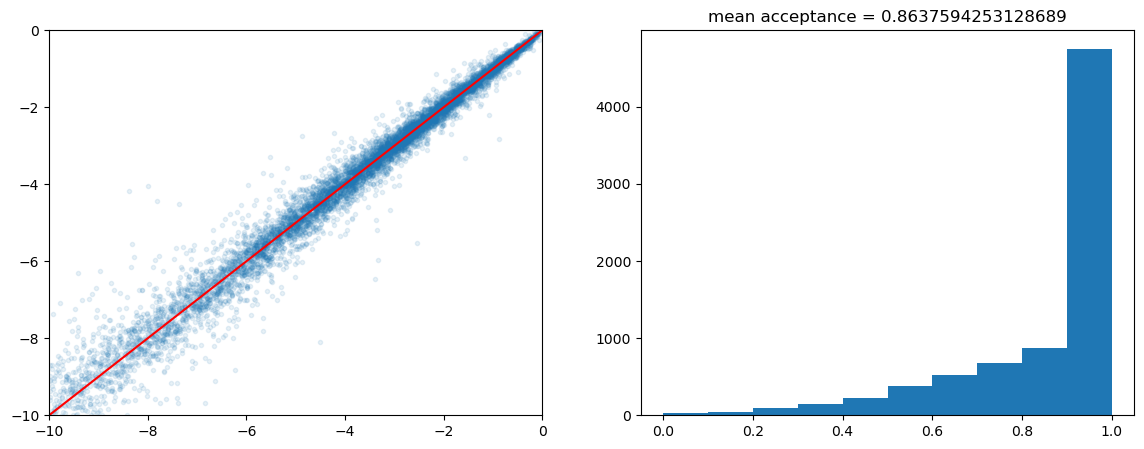

In [64]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Creating a simple neural network in PyTorch


class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for the training set
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust the batch size

# Create the model
model = Net(X_train.shape[1], y_train.shape[1])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Decrease the learning rate

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# Train the model
num_epochs = 50000
best_loss = np.inf
patience, trials = 1000, 0

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust the learning rate based on the loss
    scheduler.step(loss)

    print('Epoch [{}/{}], Loss: {:.4f}, min Loss reached {:.4f}, stagnating for {} it.'.format(epoch +
          1, num_epochs, loss.item(), best_loss, trials))

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f'Stopping early at epoch {epoch+1}')
            break

# Test the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert tensor to numpy array
res_surr = y_pred_tensor.numpy()


# Compute alphas and plot results
plot_results_all(res_surr)
